# Importing libraries

In [1]:
import nltk
import glob
import os
import numpy as np
import string
import pickle

In [2]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
from tqdm import tqdm
from sklearn import utils
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from collections import Counter
from collections import defaultdict

In [64]:
X_train_text = []
Y_train = []
X_test_text =[]
Y_test =[]
Vocab = {}
VocabFile = "aclImdb/imdb.vocab"

# Create Vocabulary Function

In [ ]:
def CreateVocab():
    with open(VocabFile, encoding='latin-1') as f:
        words = f.read().splitlines()
        stop_words = set(stopwords.words('english'))
        i=0
        for word in words:
            if word not in stop_words:
                Vocab[word] = i
                i+=1
        print(len(Vocab))

# Cleaning Data

In [93]:
def clean_review(text):
    tokens = word_tokenize(text)
    tokens = [w.lower() for w in tokens]
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    return words

# Generating Word Matrices

In [67]:
def BoWMatrix(docs):
    vectorizer = CountVectorizer(binary=True,vocabulary = Vocab)
    Doc_Term_matrix = vectorizer.fit_transform(docs)
    return Doc_Term_matrix

def TfidfMatrix(docs):
    vectorizer = TfidfVectorizer(vocabulary = Vocab,norm = 'l1')
    Doc_Term_matrix = vectorizer.fit_transform(docs)
    return Doc_Term_matrix

# ROC Curve Function

In [68]:
def ROC(Y_train, pred1, Y_test, pred2):
    fpr1, tpr1, thresholds1 = roc_curve(Y_train, pred1)
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    pyplot.plot(fpr1, tpr1, marker='.', color='blue', label="Train", linewidth=1.0)
    fpr2, tpr2, thresholds2 = roc_curve(Y_test, pred2)
    pyplot.plot(fpr2, tpr2, marker='.', color='red', label="Test", linewidth=1.0)
    pyplot.legend()
    pyplot.show()

In [69]:
def ROC2(X, pred, pred1, pred2):
    fpr, tpr, thresholds = roc_curve(X, pred)
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    pyplot.plot(fpr, tpr, marker='.')
    fpr1, tpr1, thresholds1 = roc_curve(X, pred1)
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    pyplot.plot(fpr1, tpr1, marker='.')
    fpr2, tpr2, thresholds2 = roc_curve(X, pred2)
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    pyplot.plot(fpr2, tpr2, marker='.')
    pyplot.show()

# Naive Bayes Function

In [70]:
def NB(X,Y_train,Xtest,Y_test,mtype):
    if mtype == "Bow":
        model = BernoulliNB()
    elif mtype == "Tfidf":
        model = MultinomialNB()
    else:
        model = GaussianNB()
    model.fit(X,Y_train)
    pred1 = model.predict(X)
    pred2 = model.predict(Xtest)
    acc1 = accuracy_score(Y_train,pred1)
    acc2 = accuracy_score(Y_test,pred2)
    print("NaiveBayes + " + mtype + " Train Accuracy: " + str(acc1*100) + "%")
    print("NaiveBayes + " + mtype + " Test Accuracy: " + str(acc2*100) + "%")
    prob1 = model.predict_proba(X)
    prob1 = prob1[:, 1]
    prob2 = model.predict_proba(Xtest)
    prob2 = prob2[:, 1]
    #ROC(Y_train, pred1, Y_test, pred2)
    ROC(Y_train, prob1, Y_test, prob2)

# Logistic Regression Function

In [71]:
def LR(X,Y_train,Xtest,Y_test,mtype):
    model = LogisticRegression()
    model.fit(X,Y_train)
    pred1 = model.predict(X)
    pred2 = model.predict(Xtest)
    acc1 = accuracy_score(Y_train,pred1)
    acc2 = accuracy_score(Y_test,pred2)
    print("LogisticRegression + " + mtype + " Train Accuracy: " + str(acc1*100) + "%")
    print("LogisticRegression + " + mtype + " Test Accuracy: " + str(acc2*100) + "%")
    prob1 = model.predict_proba(X)
    prob1 = prob1[:, 1]
    prob2 = model.predict_proba(Xtest)
    prob2 = prob2[:, 1]
    #ROC(Y_train, pred1, Y_test, pred2)
    ROC(Y_train, prob1, Y_test, prob2)

# Random Forest  Function

In [72]:
def RF(X,Y_train,Xtest,Y_test,mtype):
    if mtype == "Bow":
        n = 400
        md = 100
    elif mtype == "Tfidf":
        n = 400
        md = 100
    else:
        n = 100
        md = 10
    model = RandomForestClassifier(n_estimators=n, bootstrap=True, 
                                max_depth=md, max_features='auto', 
                                min_samples_leaf=4, min_samples_split=10) 
    model.fit(X,Y_train)
    pred1 = model.predict(X)
    pred2 = model.predict(Xtest)
    acc1 = accuracy_score(Y_train,pred1)
    acc2 = accuracy_score(Y_test,pred2)
    print("RandomForest + " + mtype + " Train Accuracy: " + str(acc1*100) + "%")
    print("RandomForest + " + mtype + " Test Accuracy: " + str(acc2*100) + "%")
    prob1 = model.predict_proba(X)
    prob1 = prob1[:, 1]
    prob2 = model.predict_proba(Xtest)
    prob2 = prob2[:, 1]
    #ROC(Y_train, pred1, Y_test, pred2)
    ROC(Y_train, prob1, Y_test, prob2)

# Support Vector Machine Function

In [73]:
def SVM(X,Y_train,Xtest,Y_test,mtype):
    model = LinearSVC()
    model.fit(X,Y_train)
    pred1 = model.predict(X)
    pred2 = model.predict(Xtest)
    acc1 = accuracy_score(Y_train,pred1)
    acc2 = accuracy_score(Y_test,pred2)
    print("SVM + " + mtype + " Train Accuracy: " + str(acc1*100) + "%")
    print("SVM + " + mtype + " Test Accuracy: " + str(acc2*100) + "%")
    ROC(Y_train, pred1, Y_test, pred2)

# Forward Feed Neural Network Function

In [74]:
def NN(X,Y_train,Xtest,Y_test,mtype):
    model = MLPClassifier(hidden_layer_sizes=(10,10),activation='relu',max_iter=200)
    model.fit(X,Y_train)
    pred1 = model.predict(X)
    pred2 = model.predict(Xtest)
    acc1 = accuracy_score(Y_train,pred1)
    acc2 = accuracy_score(Y_test,pred2)
    print("FFN + " + mtype + " Train Accuracy: " + str(acc1*100) + "%")
    print("FFN + " + mtype + " Test Accuracy: " + str(acc2*100) + "%")
    prob1 = model.predict_proba(X)
    prob1 = prob1[:, 1]
    prob2 = model.predict_proba(Xtest)
    prob2 = prob2[:, 1]
    #ROC(Y_train, pred1, Y_test, pred2)
    ROC(Y_train, prob1, Y_test, prob2)

# Loading Data

In [4]:
path1 = 'aclImdb/train/pos/*.txt'
path2 = 'aclImdb/train/neg/*.txt'
path3 = 'aclImdb/test/pos/*.txt'
path4 = 'aclImdb/test/neg/*.txt'

files1 = glob.glob(path1)
files2 = glob.glob(path2)
files3 = glob.glob(path3)
files4 = glob.glob(path4)

In [77]:
#Positive labels
for i,filename in enumerate(files1):
    f = open(filename,"r+", encoding='latin-1')
    text = f.read()
    f.close()
    X_train_text.append(text)
    Y_train.append(1)

#Neg labels
for j,filename in enumerate(files2):
    f = open(filename,"r+", encoding='latin-1')
    text = f.read()
    f.close()
    X_train_text.append(text)
    Y_train.append(0)

#Test labels +
for k,filename in enumerate(files3):
    f = open(filename,"r+", encoding='latin-1')
    text = f.read()
    f.close()
    X_test_text.append(text)
    Y_test.append(1)

#Test labels +
for l,filename in enumerate(files4):
    f = open(filename,"r+", encoding='latin-1')
    text = f.read()
    f.close()
    X_test_text.append(text)
    Y_test.append(0)

CreateVocab();

89356


# Generating Word Matrix for Test & Train Data

In [75]:
def Getbowvec(X_train_text,Y_train,X_test_text,Y_test):
    X = BoWMatrix(X_train_text)
    Xtest = BoWMatrix(X_test_text)
    return X,Xtest

def Gettfidfvec(X_train_text,Y_train,X_test_text,Y_test):
    X = TfidfMatrix(X_train_text)
    Xtest = TfidfMatrix(X_test_text)
    return X,Xtest

# Doc2Vec Representation

In [79]:
'''
def LabelRev(reviews,label_string):
    result = []
    prefix = label_string
    for i, t in enumerate(reviews):
        # print(t)
        result.append(LabeledSentence(t, [prefix + '_%s' % i]))
    return result

LabelledXtrain = LabelRev(X_train_text,"review")    
LabelledXtest = LabelRev(X_test_text,"test")

LabelledData = LabelledXtrain + LabelledXtest

modeld2v = Doc2Vec(dm=1, min_count=2, alpha=0.065, min_alpha=0.065)
modeld2v.build_vocab([x for x in tqdm(LabelledData)])

print("Training the Doc2Vec Model.....")
for epoch in range(50):
    print("epoch : ",epoch)
    modeld2v.train(utils.shuffle([x for x in tqdm(LabelledData)]), total_examples=len(LabelledData), epochs=1)
    modeld2v.alpha -= 0.002
    modeld2v.min_alpha = modeld2v.alpha
    
print("Saving Doc2Vec1 Model....")
modeld2v.save('doc2vec1.model')
#print("Saving Doc2Vec Model....")
#modeld2v.save('doc2vec.model')  
'''

'\ndef LabelRev(reviews,label_string):\n    result = []\n    prefix = label_string\n    for i, t in enumerate(reviews):\n        # print(t)\n        result.append(LabeledSentence(t, [prefix + \'_%s\' % i]))\n    return result\n\nLabelledXtrain = LabelRev(X_train_text,"review")    \nLabelledXtest = LabelRev(X_test_text,"test")\n\nLabelledData = LabelledXtrain + LabelledXtest\n\nmodeld2v = Doc2Vec(dm=1, min_count=2, alpha=0.065, min_alpha=0.065)\nmodeld2v.build_vocab([x for x in tqdm(LabelledData)])\n\nprint("Training the Doc2Vec Model.....")\nfor epoch in range(50):\n    print("epoch : ",epoch)\n    modeld2v.train(utils.shuffle([x for x in tqdm(LabelledData)]), total_examples=len(LabelledData), epochs=1)\n    modeld2v.alpha -= 0.002\n    modeld2v.min_alpha = modeld2v.alpha\n    \nprint("Saving Doc2Vec1 Model....")\nmodeld2v.save(\'doc2vec1.model\')\n#print("Saving Doc2Vec Model....")\n#modeld2v.save(\'doc2vec.model\')  \n'

In [85]:
def Doc2vec(X_train_text,Y_train,X_test_text,Y_test):
    model = Doc2Vec.load('doc2vec.model')
    #model = Doc2Vec.load('doc2vec1.model')
    X = []
    Xtest =[]
    for i,l in enumerate(X_train_text):
        temp = "review" + "_" + str(i)
        X.append(model.docvecs[temp])
    for i,l in enumerate(X_test_text):
        temp = "test" + "_" + str(i)
        Xtest.append(model.docvecs[temp])
    return X,Xtest

In [86]:
print("Bag of Words is being built...")
X,Xtest = Getbowvec(X_train_text,Y_train,X_test_text,Y_test)

print("Tf-idf is being built...")
X1,Xtest1 = Gettfidfvec(X_train_text,Y_train,X_test_text,Y_test)

print("Doc2Vec is being built...")
X2,Xtest2 = Doc2vec(X_train_text,Y_train,X_test_text,Y_test)

Bag of Words is being built...
Tf-idf is being built...
Doc2Vec is being built...


In [112]:
len(X[0])

[ 3.8730502e-01 -2.4226126e-01  1.8447070e-01  2.7821556e-01
  5.6896007e-01  2.4535358e-01 -2.5278392e-01  1.5472387e-01
 -1.1508914e-01  4.5354521e-01  3.8365748e-02 -2.5258625e-01
 -5.8337015e-01  1.0790733e+00 -1.6636238e-01  4.3921784e-02
  6.0108167e-01 -7.4332672e-01 -3.5194703e-03  5.2995592e-01
 -4.6524012e-01 -2.2355888e-02  8.3163187e-02 -3.0640143e-01
 -7.0134312e-01  6.8939185e-01  2.0314547e-01 -4.4697830e-01
 -1.9118084e-02 -1.1067226e-01 -3.0236110e-01  3.7518761e-01
 -5.2174801e-01 -6.5070170e-01  4.4410905e-01 -3.6672121e-01
 -6.6573453e-01 -7.9081794e-03 -9.3441790e-01  1.5675272e-01
  2.4286245e-01 -5.1078118e-02  2.6444617e-01  1.8430072e-01
 -3.6135960e-01  1.0735059e+00 -1.7230248e-01  1.9120649e-01
  2.9940462e-01  1.2391033e+00 -3.0393973e-01  2.6779616e-01
  4.8723632e-01  2.8240904e-03 -2.5652254e-01  1.0942936e+00
  6.4555228e-01 -6.1286968e-01  8.6758316e-01 -1.3204034e-01
  3.7257919e-01 -2.8581244e-01  7.1880788e-01  2.4354255e-01
  8.9242440e-01 -6.61569

# Applying Classification Algorithms

Naive Bayes:
NaiveBayes + Bow Train Accuracy: 90.38000000000001%
NaiveBayes + Bow Test Accuracy: 81.872%


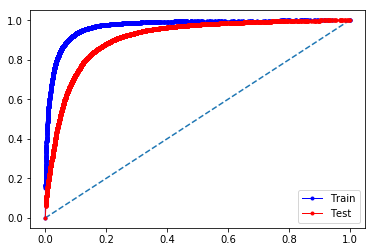

NaiveBayes + Tfidf Train Accuracy: 89.60000000000001%
NaiveBayes + Tfidf Test Accuracy: 85.048%


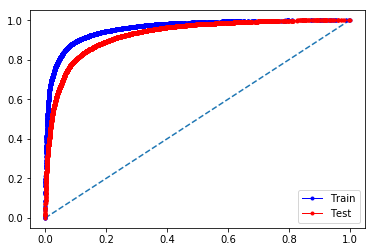

NaiveBayes + Doc2Vec Train Accuracy: 86.168%
NaiveBayes + Doc2Vec Test Accuracy: 86.444%


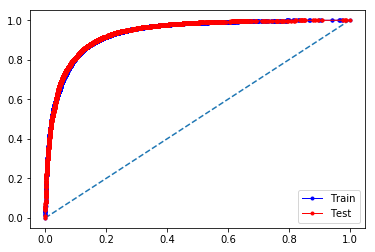

In [87]:
print("Naive Bayes:")
NB(X,Y_train,Xtest,Y_test,"Bow")
NB(X1,Y_train,Xtest1,Y_test,"Tfidf")
NB(X2,Y_train,Xtest2,Y_test,"Doc2Vec")

Logistic Regression:
LogisticRegression + Bow Train Accuracy: 99.752%
LogisticRegression + Bow Test Accuracy: 86.86399999999999%


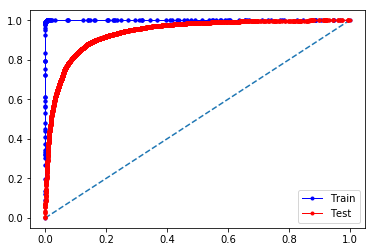

LogisticRegression + Tfidf Train Accuracy: 83.82%
LogisticRegression + Tfidf Test Accuracy: 82.84%


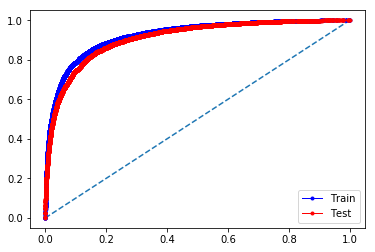

LogisticRegression + Doc2Vec Train Accuracy: 87.968%
LogisticRegression + Doc2Vec Test Accuracy: 88.14800000000001%


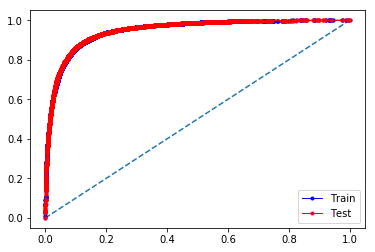

In [88]:
print("Logistic Regression:")
LR(X,Y_train,Xtest,Y_test,"Bow")
LR(X1,Y_train,Xtest1,Y_test,"Tfidf")
LR(X2,Y_train,Xtest2,Y_test,"Doc2Vec")

Random Forest:
RandomForest + Bow Train Accuracy: 93.58800000000001%
RandomForest + Bow Test Accuracy: 86.572%


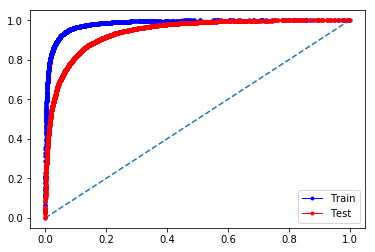

RandomForest + Tfidf Train Accuracy: 95.916%
RandomForest + Tfidf Test Accuracy: 86.05199999999999%


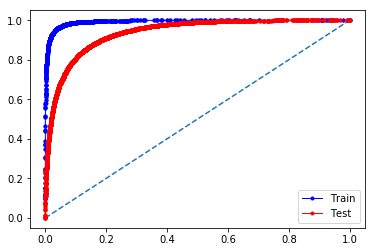

RandomForest + Doc2Vec Train Accuracy: 95.136%
RandomForest + Doc2Vec Test Accuracy: 81.632%


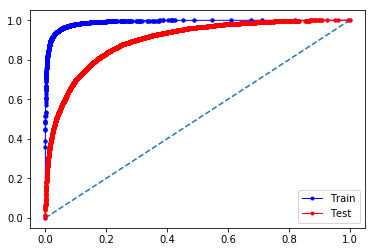

In [89]:
print("Random Forest:")
RF(X,Y_train,Xtest,Y_test,"Bow")
RF(X1,Y_train,Xtest1,Y_test,"Tfidf")
RF(X2,Y_train,Xtest2,Y_test,"Doc2Vec")

SVM:
SVM + Bow Train Accuracy: 100.0%
SVM + Bow Test Accuracy: 84.892%


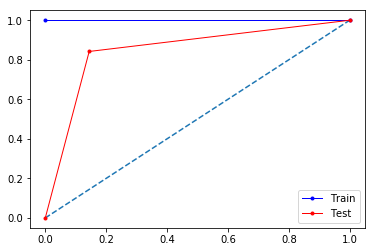

SVM + Tfidf Train Accuracy: 89.27199999999999%
SVM + Tfidf Test Accuracy: 86.848%


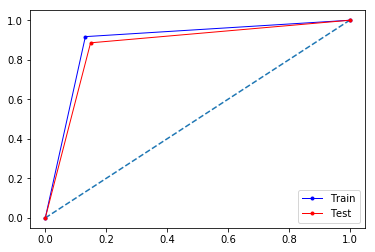

SVM + Doc2Vec Train Accuracy: 87.952%
SVM + Doc2Vec Test Accuracy: 88.152%


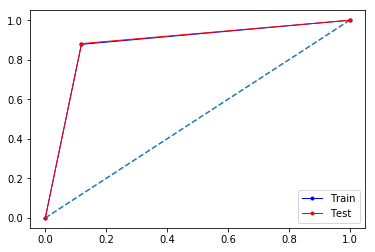

In [90]:
print("SVM:")
SVM(X,Y_train,Xtest,Y_test,"Bow")
SVM(X1,Y_train,Xtest1,Y_test,"Tfidf")
SVM(X2,Y_train,Xtest2,Y_test,"Doc2Vec")

Neural Networks:
FFN + Bow Train Accuracy: 100.0%
FFN + Bow Test Accuracy: 85.6%


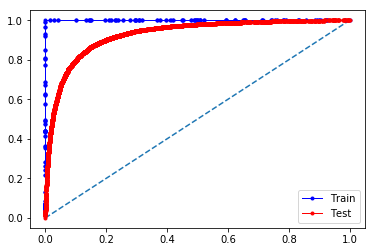

FFN + Tfidf Train Accuracy: 100.0%
FFN + Tfidf Test Accuracy: 85.84%


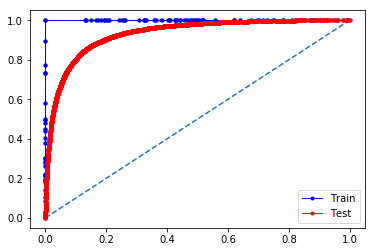

FFN + Doc2Vec Train Accuracy: 89.776%
FFN + Doc2Vec Test Accuracy: 87.30799999999999%


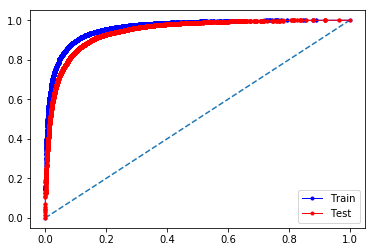

In [91]:
print("Neural Networks:")
NN(X,Y_train,Xtest,Y_test,"Bow")
NN(X1,Y_train,Xtest1,Y_test,"Tfidf")
NN(X2,Y_train,Xtest2,Y_test,"Doc2Vec")